# Data Science Project - Group 7

## Marketing Mix Modeling (MMM) for an Ecommerce Brand

MMM is an econometric model that aims to quantify the incremental impact of marketing and non-marketing activities on a pre-defined KPI (like sales or website visits).

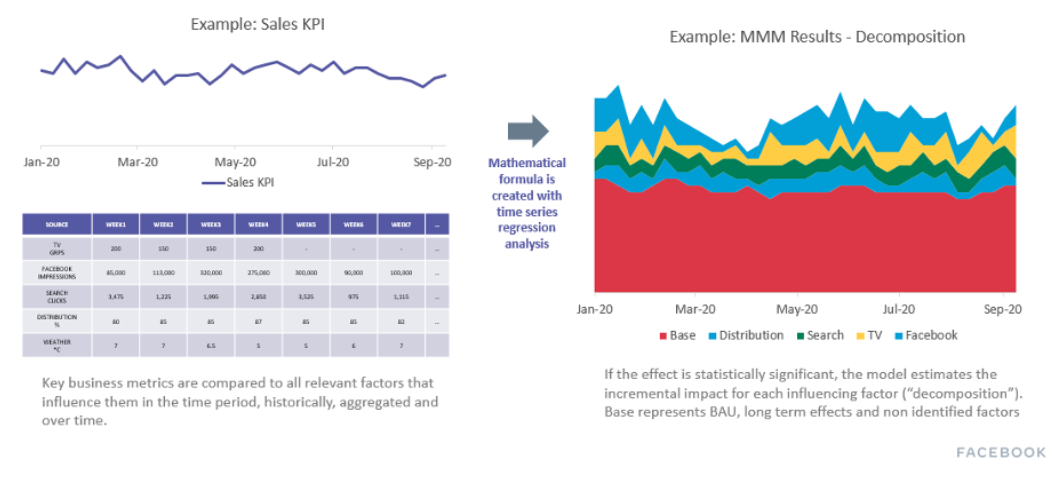


## Regression Model Form With Non Linear Transformations on Marketing Variables

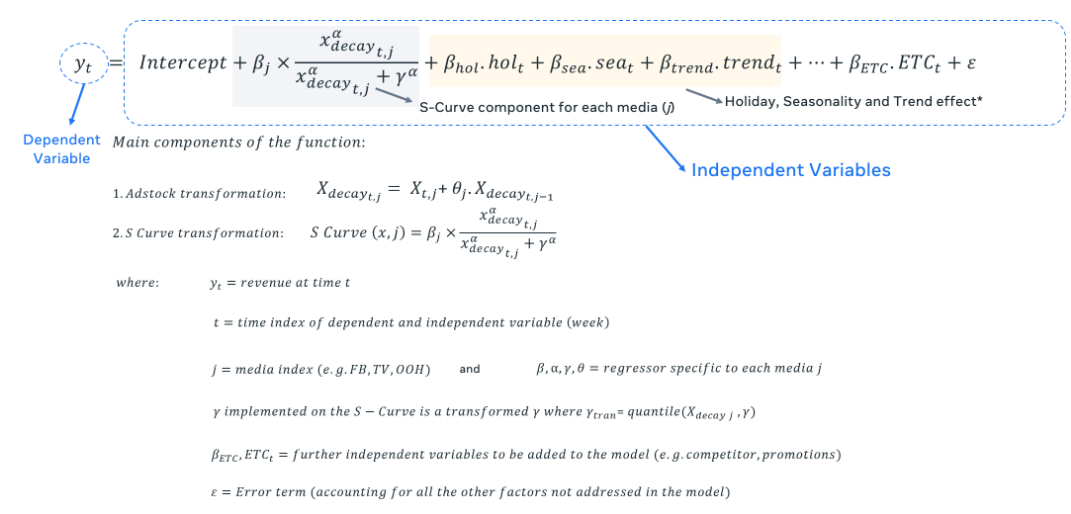


## Notebook Contents


  1.   Data Preparation for Model
  2.   Exploratory Data Analysis (EDA)
  3.   Model Building & Inference
  4.   Model Diagnostics



Installs necessary Python packages, including updating pip and installing lightweight_mmm (commented for optional execution).


In [ ]:
# !pip install --upgrade pip
# !pip install --upgrade git+https://github.com/google/lightweight_mmm.git


Imports essential Python libraries


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, r2_score
from lightweight_mmm import preprocessing, lightweight_mmm, plot, utils
import jax.numpy as jnp
import numpyro
numpyro.set_host_device_count(10)

# turn off SettingWithCopyWarning
pd.options.mode.chained_assignment = None

Mounts Google Drive to access shared files.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# define file paths
client_dir = '/content/drive/My Drive/Projects/ClassProj/'
file_path = client_dir + 'data/Raw_Data_ClassProj.xlsx'


Mounted at /content/drive/


# 1. Data Preparation

### Read Sales (Dependent Variable) Data

In [ ]:
raw_shopify_df = pd.read_excel(file_path, sheet_name='Shopify')
raw_shopify_df.head()


,Day,CustomerType,Sales
0,2022-04-23,FirstTime,382.0
1,2022-04-23,Returning,19334.0
2,2022-04-24,FirstTime,19514.0
3,2022-04-24,Returning,40507.0
4,2022-04-25,FirstTime,15956.0


Verify if data types look correct

In [ ]:
# Check data types
raw_shopify_df.dtypes

,0
Day,datetime64[ns]
CustomerType,object
Sales,float64


Check of missing values

In [ ]:
# Check for missing values
raw_shopify_df.isnull().sum()


,0
Day,0
CustomerType,0
Sales,0


Let's look at the proportion of sales from New Customers vs Returning Customers

In [ ]:
def size_of_category(input_df, category_columns, value_column):

  # group by category and agg value
  grouped_df = input_df.groupby(category_columns).agg({value_column: 'sum'}).reset_index()

  # calculate total
  total = grouped_df[value_column].sum()

  # calculate percentage
  grouped_df['%'] = (grouped_df[value_column] / total).round(2)

  # Sort by % from largest to smallest
  size_df = grouped_df.sort_values(by='%', ascending=False).reset_index(drop=True)


  return size_df

# sales by customer type
size_of_category(input_df=raw_shopify_df, category_columns=['CustomerType'], value_column='Sales')

,CustomerType,Sales,%
0,Returning,24124398.99,0.63
1,FirstTime,13899101.62,0.37


The modeling would be done at Weekly level since we expect lower noise at Weekly level as compared to daily level

So let's convert our sales data to weekly level

In [ ]:
def to_week_start_monday(input_df, day_column='Day'):

    # Map each 'Day' to the nearest Monday and create a new column for it
    input_df['Week'] = input_df[day_column] - pd.to_timedelta(input_df[day_column].dt.weekday, unit='d')

    # Extract the 'Week' column
    week_column = input_df.pop('Week')

    # Insert the 'Week' column as the first column
    input_df.insert(0, 'Week', week_column)

    return input_df


# Create 'Week' - Week Starting Monday format
raw_shopify_df = to_week_start_monday(raw_shopify_df, day_column='Day')

# Drop 'Day'
raw_shopify_df.drop(columns=['Day'], inplace=True)


Let's aggregate the Sales data by Week and CustomerType

In [ ]:
# Group by Week and customer_type, then aggregate orders and sales to create sales_agg dataframe
sales_agg_df = raw_shopify_df.groupby(['Week', 'CustomerType']).agg({'Sales': 'sum'}).reset_index()
sales_agg_df.head()

,Week,CustomerType,Sales
0,2022-04-18,FirstTime,19896.0
1,2022-04-18,Returning,59841.0
2,2022-04-25,FirstTime,94773.0
3,2022-04-25,Returning,145218.4
4,2022-05-02,FirstTime,110844.0


The model requires data to be pivoted so let's do the transformation

In [ ]:
def pivot_category(input_df, index_column, columns_to_pivot, values_to_pivot):

    # Pivot the DataFrame to keep 'Tactic' in columns and both 'Spend' and 'Impressions' in values
    input_df = input_df.pivot_table(index=index_column, columns=columns_to_pivot, values=values_to_pivot)

    # Flatten the columns of the pivoted DataFrame
    input_df.columns = [col[1] + "_" + col[0] if isinstance(col, tuple) else col for col in input_df.columns.values]

    # for ease of processing, let's replace the blanks and hypens in the column names
    input_df.columns = [col.replace(' ', '_').replace('-', '_') for col in input_df.columns]

    input_df = input_df.reset_index()

    return input_df

sales_pivoted_df = pivot_category(input_df=sales_agg_df, index_column='Week', columns_to_pivot=['CustomerType'], values_to_pivot=['Sales'])
sales_pivoted_df.head()

,Week,FirstTime_Sales,Returning_Sales
0,2022-04-18,19896.0,59841.0
1,2022-04-25,94773.0,145218.4
2,2022-05-02,110844.0,179390.4
3,2022-05-09,134153.0,201627.2
4,2022-05-16,145968.8,199208.0


Sanity check! Check for missing values in the pivoted data.

In [ ]:
# check any missing values
sales_pivoted_df.isnull().sum()

,0
Week,0
FirstTime_Sales,0
Returning_Sales,0


Let's visualize Weekly sales and make sure data looks alright

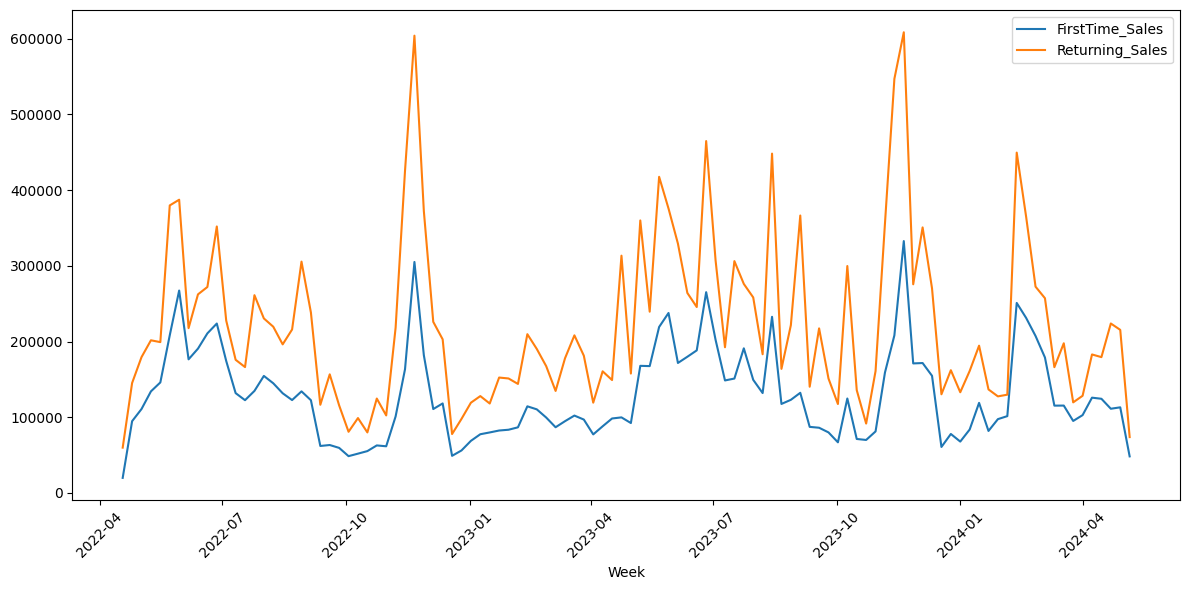

In [ ]:
def plot_category_level_weekly_line_graph(df, category=None):

    # Filter the DataFrame to keep only columns that contain channel and the 'Week' column
    category_df = df.filter(regex=f'Week|{category}')

    # Plot a weekly line graph
    plt.figure(figsize=(12, 6))
    for column in category_df.columns:
        if column != 'Week':
            plt.plot(category_df['Week'], category_df[column], label=column)

    plt.xlabel('Week')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return None

plot_category_level_weekly_line_graph(df=sales_pivoted_df, category='Sales')

First and last data points look anamolous because the data in first and the last week are not complete - so let's remove them

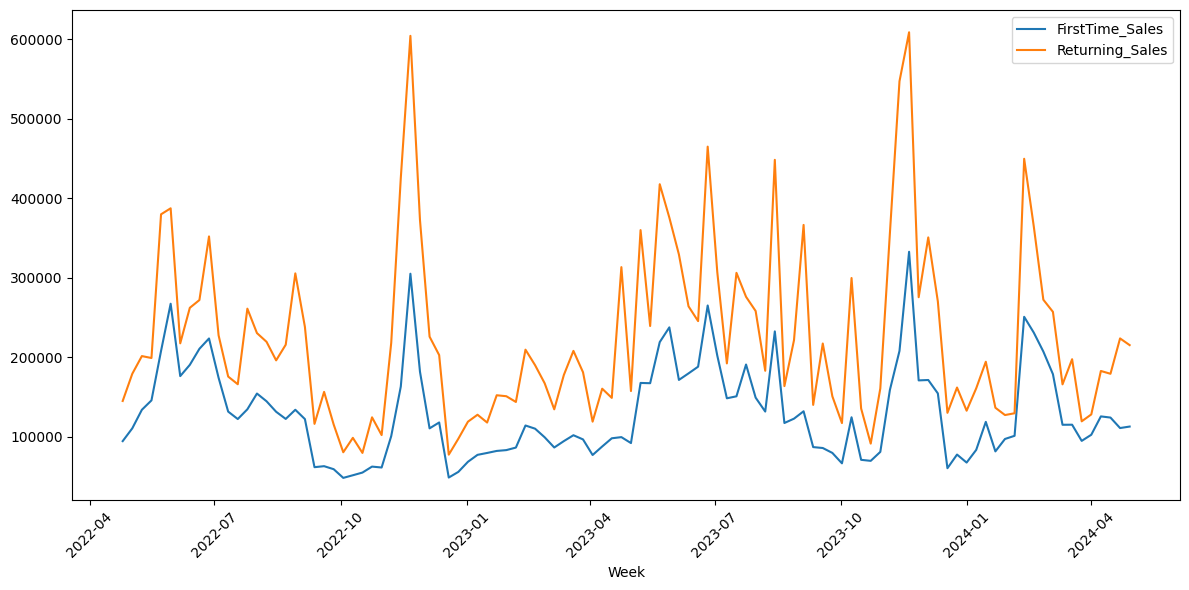

In [ ]:
# let's remove the first and last Week from sales_pivoted_df
sales_pivoted_df = sales_pivoted_df.iloc[1:-1]

plot_category_level_weekly_line_graph(df=sales_pivoted_df, category='Sales')

### Media Data (Independent Variables)
1. Let's read **FB** data

In [ ]:
raw_fb_df = pd.read_excel(file_path, sheet_name='FB')
raw_fb_df.head()

,Day,Customer Segment,Campaign name,Ad set name,Impressions,Clicks,Spend,Purchases,Purchases conversion value
0,2022-12-31,Remarketing,RE_y:ASC_a:Mix_b:Mixed_d:ABO-7DC Campaign,RE_y:ASC_a:Mix_b:Mixed_d:ABO-7DC Ad set,31254.0,651.0,249.01,4.0,348.46
1,2022-12-30,Remarketing,RE_y:ASC_a:Mix_b:Mixed_d:ABO-7DC Campaign,RE_y:ASC_a:Mix_b:Mixed_d:ABO-7DC Ad set,22830.0,537.0,213.94,7.0,341.40
2,2022-12-29,Remarketing,RE_y:ASC_a:Mix_b:Mixed_d:ABO-7DC Campaign,RE_y:ASC_a:Mix_b:Mixed_d:ABO-7DC Ad set,21569.0,568.0,213.82,5.0,380.00
3,2022-12-28,Remarketing,RE_y:ASC_a:Mix_b:Mixed_d:ABO-7DC Campaign,RE_y:ASC_a:Mix_b:Mixed_d:ABO-7DC Ad set,23714.0,662.0,214.80,3.0,158.00
4,2022-12-27,Remarketing,RE_y:ASC_a:Mix_b:Mixed_d:ABO-7DC Campaign,RE_y:ASC_a:Mix_b:Mixed_d:ABO-7DC Ad set,25606.0,661.0,218.31,4.0,208.40


Let's do sanity checks such as

1.   Data type check
2.   Look at number of levels within each dimension
3.   check for any missing values



In [ ]:
# check data types
print(raw_fb_df.dtypes, "\n")

# number of unique levels/values in dimensions
print(raw_fb_df.nunique(), "\n")

# check for missing values
print(raw_fb_df.isnull().sum(), "\n")


Day                           datetime64[ns]
Customer Segment                      object
Campaign name                         object
Ad set name                           object
Impressions                          float64
Clicks                               float64
Spend                                float64
Purchases                            float64
Purchases conversion value           float64
dtype: object 

Day                            874
Customer Segment                 4
Campaign name                   78
Ad set name                    277
Impressions                   6933
Clicks                        1350
Spend                         6859
Purchases                      144
Purchases conversion value    5605
dtype: int64 

Day                             0
Customer Segment                0
Campaign name                   0
Ad set name                     0
Impressions                   440
Clicks                        457
Spend                         440
Purchases  

Let's keep only the dimensions that are tractable to be modeled. We don't want to include dimensions with lots of levels as it would bring sparsity and overfitting to the model


In [ ]:
# filter out granular dimensions
raw_fb_clean_df = raw_fb_df[['Day', 'Customer Segment', 'Impressions', 'Clicks', 'Spend']].fillna(0)

# to week
raw_fb_clean_df = to_week_start_monday(raw_fb_clean_df, day_column='Day')

# drop day
raw_fb_clean_df.drop(columns=['Day'], inplace=True)

# group by Week, Customer Segment and aggregate metrics
raw_fb_clean_df = raw_fb_clean_df.groupby(['Week', 'Customer Segment']).agg({'Impressions': 'sum', 'Clicks': 'sum', 'Spend': 'sum'}).reset_index()

raw_fb_clean_df.head()


,Week,Customer Segment,Impressions,Clicks,Spend
0,2021-12-27,New Customer,382867.0,4398.0,3272.65
1,2021-12-27,Returning Customer,76964.0,287.0,749.81
2,2022-01-03,New Customer,1162150.0,14262.0,10803.90
3,2022-01-03,Returning Customer,274612.0,1009.0,2671.13
4,2022-01-10,New Customer,1118712.0,13756.0,12987.98


Now, let's look at the proportion of Spend by Customer Segment giving us hint about any redundancy in the levels

In [ ]:
# spend proportion by customer segment
size_of_category(input_df=raw_fb_clean_df, category_columns=['Customer Segment'], value_column='Spend')

,Customer Segment,Spend,%
0,New Customer,1039309.58,0.45
1,Remarketing,699960.14,0.30
2,Prospecting,522813.84,0.23
3,Returning Customer,37537.80,0.02


We notice some redundancies such as 'New Customer' and 'Prospecting' in the same bucket. So let's collapse them and

In [ ]:
# Map 'New Customer' to 'Prospecting' and 'Returning Customer' to 'Remarketing'
raw_fb_clean_df['Customer Segment'] = raw_fb_clean_df['Customer Segment']. \
  replace({'New Customer': 'Prospecting', 'Returning Customer': 'Remarketing'})

# spend proportion by customer segment
size_of_category(input_df=raw_fb_clean_df, category_columns=['Customer Segment'], value_column='Spend')


,Customer Segment,Spend,%
0,Prospecting,1562123.42,0.68
1,Remarketing,737497.94,0.32


In [ ]:
# for convenience, let's call 'Prospecting' as 'FB_Prospecting' and 'Remarketing' as 'FB_Remarketing'
raw_fb_clean_df['Customer Segment'] = raw_fb_clean_df['Customer Segment']. \
  replace({'Prospecting': 'FB_Prospecting', 'Remarketing': 'FB_Remarketing'})

In [ ]:
# Group by and aggregate
raw_fb_agg_df = raw_fb_clean_df.groupby(['Week', 'Customer Segment']).agg({'Impressions': 'sum', 'Clicks': 'sum', 'Spend': 'sum'}).reset_index()

# let's transform by pivoting
fb_pivoted_df = pivot_category(
    input_df=raw_fb_agg_df,
    index_column='Week',
    columns_to_pivot=['Customer Segment'],
    values_to_pivot=['Impressions', 'Clicks', 'Spend']).fillna(0)

print(fb_pivoted_df.shape)

fb_pivoted_df.head()


(126, 7)


,Week,FB_Prospecting_Clicks,FB_Remarketing_Clicks,FB_Prospecting_Impressions,FB_Remarketing_Impressions,FB_Prospecting_Spend,FB_Remarketing_Spend
0,2021-12-27,4398.0,287.0,382867.0,76964.0,3272.65,749.81
1,2022-01-03,14262.0,1009.0,1162150.0,274612.0,10803.90,2671.13
2,2022-01-10,13756.0,888.0,1118712.0,203386.0,12987.98,2307.83
3,2022-01-17,7626.0,572.0,695783.0,143939.0,8594.28,1750.35
4,2022-01-24,2207.0,442.0,218721.0,64407.0,2913.49,742.65


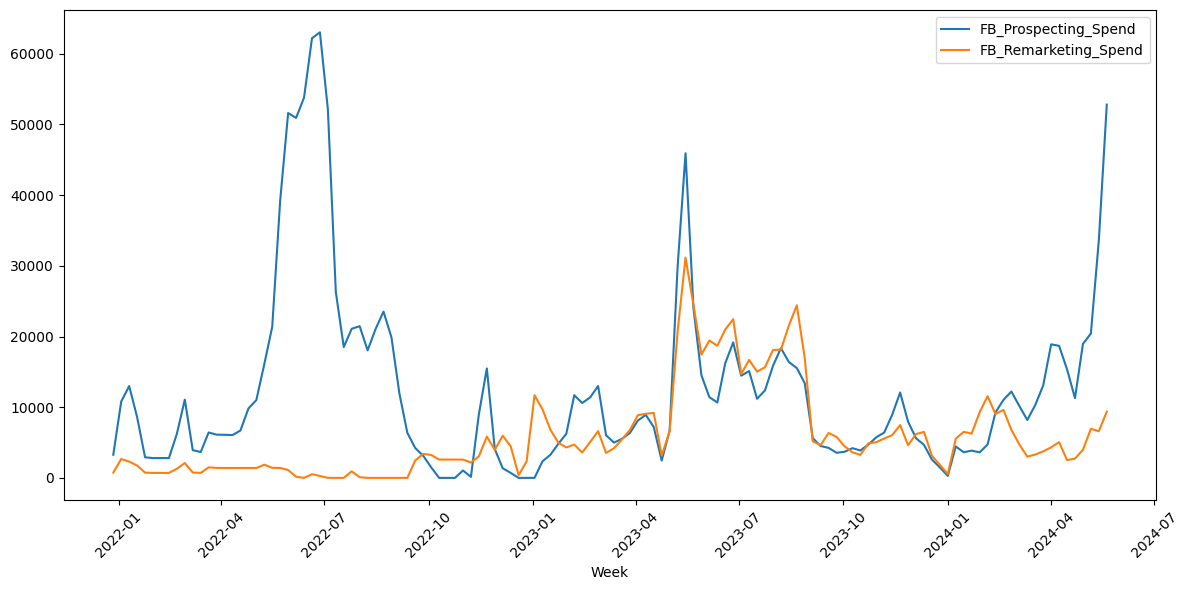

In [ ]:
# let's plot weekly Spend by category
plot_category_level_weekly_line_graph(df=fb_pivoted_df, category='Spend')

In [ ]:
# Plot FB vs New Customer Sales

2. Google

In [ ]:
# now, let's process and clean adwords data the way we did for FB

# 1. read file
raw_adwords_df = pd.read_excel(file_path, sheet_name='Adwords')

raw_adwords_df.dtypes

,0
Day,datetime64[ns]
Channel,object
Campaign,object
Campaign type,object
Customer Segment,object
Impressions,float64
Clicks,float64
Spend,float64
Conversions,float64
Conv. value,float64


In [ ]:
raw_adwords_df.head()

,Day,Channel,Campaign,Campaign type,Customer Segment,Impressions,Clicks,Spend,Conversions,Conv. value
0,2024-02-27,Non-Brand Search,[NB] Non-Brand_ALL,Search,Acquisition,2158.0,75.0,225.39,2.00,197.61
1,2024-02-28,Non-Brand Search,[NB] Non-Brand_ALL,Search,Acquisition,2586.0,139.0,300.84,6.76,712.02
2,2024-02-29,Non-Brand Search,[NB] Non-Brand_ALL,Search,Acquisition,2218.0,112.0,299.35,2.48,202.46
3,2024-03-01,Non-Brand Search,[NB] Non-Brand_ALL,Search,Acquisition,2371.0,122.0,294.90,1.38,326.32
4,2024-03-02,Non-Brand Search,[NB] Non-Brand_ALL,Search,Acquisition,2594.0,155.0,316.65,5.00,610.19


In [ ]:
# filter out granular dimensions
raw_adwords_clean_df = raw_adwords_df[['Day', 'Channel', 'Impressions', 'Clicks', 'Spend']].fillna(0)

# to week
raw_adwords_clean_df = to_week_start_monday(raw_adwords_clean_df, day_column='Day')

# drop day
raw_adwords_clean_df.drop(columns=['Day'], inplace=True)

# group by Week, Customer Segment and aggregate metrics
raw_adwords_agg_df = raw_adwords_clean_df.groupby(['Week', 'Channel']).agg({'Impressions': 'sum', 'Clicks': 'sum', 'Spend': 'sum'}).reset_index()

# proportion of Spend by channel
size_of_category(input_df=raw_adwords_agg_df, category_columns=['Channel'], value_column='Spend')

,Channel,Spend,%
0,PMAX,777821.50,0.48
1,Shopping,282508.00,0.18
2,Non-Brand Search,274515.57,0.17
3,Brand Search,239330.49,0.15
4,Discovery,11751.97,0.01
5,Video,19933.38,0.01


In [ ]:
# now, let's transform by pivoting
adwords_pivoted_df = pivot_category(
    input_df=raw_adwords_agg_df,
    index_column='Week',
    columns_to_pivot=['Channel'],
    values_to_pivot=['Impressions', 'Clicks', 'Spend']).fillna(0)

print(adwords_pivoted_df.shape)

adwords_pivoted_df.head()


(125, 19)


,Week,Brand_Search_Clicks,Discovery_Clicks,Non_Brand_Search_Clicks,PMAX_Clicks,Shopping_Clicks,Video_Clicks,Brand_Search_Impressions,Discovery_Impressions,Non_Brand_Search_Impressions,PMAX_Impressions,Shopping_Impressions,Video_Impressions,Brand_Search_Spend,Discovery_Spend,Non_Brand_Search_Spend,PMAX_Spend,Shopping_Spend,Video_Spend
0,2021-12-27,1588.0,0.0,662.0,0.0,3165.0,0.0,3714.0,0.0,11102.0,0.0,428278.0,0.0,474.45,0.0,1147.32,0.0,1696.52,0.0
1,2022-01-03,6371.0,0.0,1131.0,0.0,10701.0,0.0,18377.0,0.0,18231.0,0.0,1535373.0,0.0,1813.37,0.0,1679.19,0.0,5438.87,0.0
2,2022-01-10,7293.0,0.0,683.0,0.0,11933.0,0.0,23352.0,0.0,9134.0,0.0,1652002.0,0.0,1955.47,0.0,834.04,0.0,6253.49,0.0
3,2022-01-17,7101.0,0.0,793.0,0.0,11873.0,0.0,21424.0,0.0,11222.0,0.0,1545937.0,0.0,2000.12,0.0,1032.31,0.0,6045.84,0.0
4,2022-01-24,6419.0,0.0,1072.0,0.0,8080.0,0.0,15056.0,0.0,14974.0,0.0,963696.0,0.0,1993.88,0.0,1507.81,0.0,3743.13,0.0


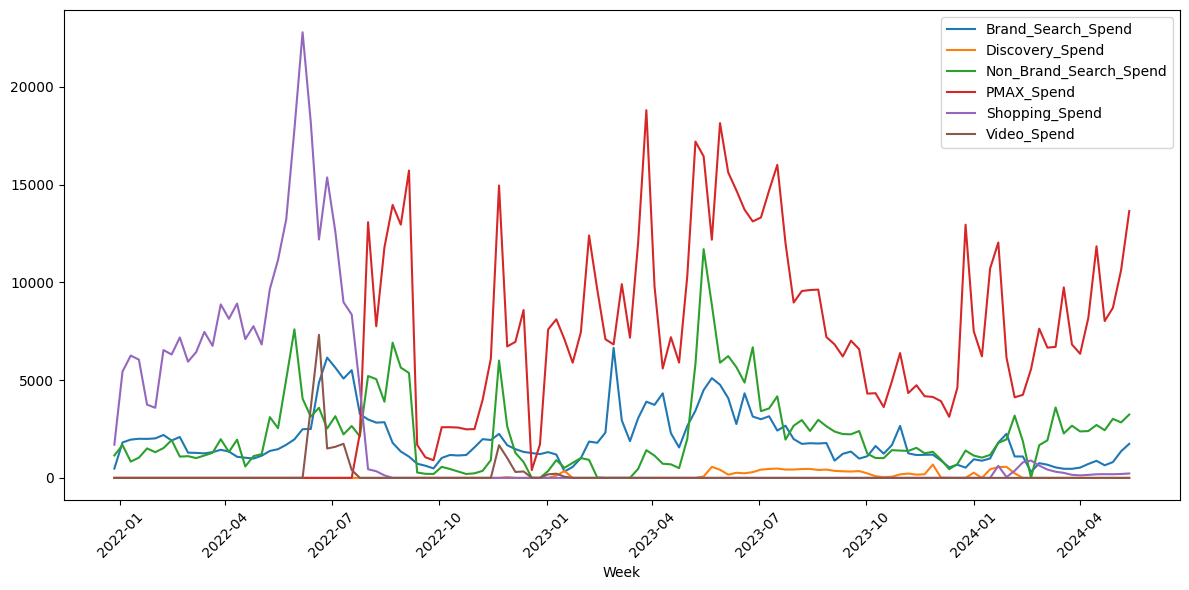

In [ ]:
# now, let's plot weekly spend
plot_category_level_weekly_line_graph(df=adwords_pivoted_df, category='Spend')

In [ ]:
# Function to calculate the proportion of records with zeros for each column except 'Week'
def calculate_zero_proportions(df):
    zero_proportions = {}
    for column in df.columns:
        if column != 'Week':
            zero_count = (df[column] == 0).sum()
            total_count = df[column].shape[0]
            zero_proportions[column] = zero_count / total_count
    return zero_proportions

# Calculate the proportion of records with zeros
zero_proportions = calculate_zero_proportions(adwords_pivoted_df[[col for col in adwords_pivoted_df if col.endswith('_Spend')]])

# Convert the zero_proportions dictionary to a DataFrame for better display
zero_proportions_df = pd.DataFrame(list(zero_proportions.items()), columns=['Category', 'Proportion of Zeros'])
zero_proportions_df.sort_values(by='Proportion of Zeros', ascending=False, inplace=True)

zero_proportions_df

,Category,Proportion of Zeros
5,Video_Spend,0.888
1,Discovery_Spend,0.696
4,Shopping_Spend,0.592
3,PMAX_Spend,0.240
2,Non_Brand_Search_Spend,0.048
0,Brand_Search_Spend,0.000


In [ ]:
# let's call Shopping as PMAX and combine Video and Discovery into one category

raw_adwords_agg_df['Channel'] = raw_adwords_agg_df['Channel'].replace({'Shopping': 'PMAX'})
raw_adwords_agg_df['Channel'] = raw_adwords_agg_df['Channel'].replace({'Discovery': 'Discovery_plus_Video'})
raw_adwords_agg_df['Channel'] = raw_adwords_agg_df['Channel'].replace({'Video': 'Discovery_plus_Video'})

# group by Week, Customer Segment and aggregate metrics
raw_adwords_agg_df2 = raw_adwords_agg_df.groupby(['Week', 'Channel']).agg({'Impressions': 'sum', 'Clicks': 'sum', 'Spend': 'sum'}).reset_index()

# proportion of Spend by channel
size_of_category(input_df=raw_adwords_agg_df2, category_columns=['Channel'], value_column='Spend')

,Channel,Spend,%
0,PMAX,1060329.50,0.66
1,Non-Brand Search,274515.57,0.17
2,Brand Search,239330.49,0.15
3,Discovery_plus_Video,31685.35,0.02


In [ ]:
# let's recreate adwords_pivoted_df
adwords_pivoted_df = pivot_category(
    input_df=raw_adwords_agg_df2,
    index_column='Week',
    columns_to_pivot=['Channel'],
    values_to_pivot=['Impressions', 'Clicks', 'Spend']).fillna(0)


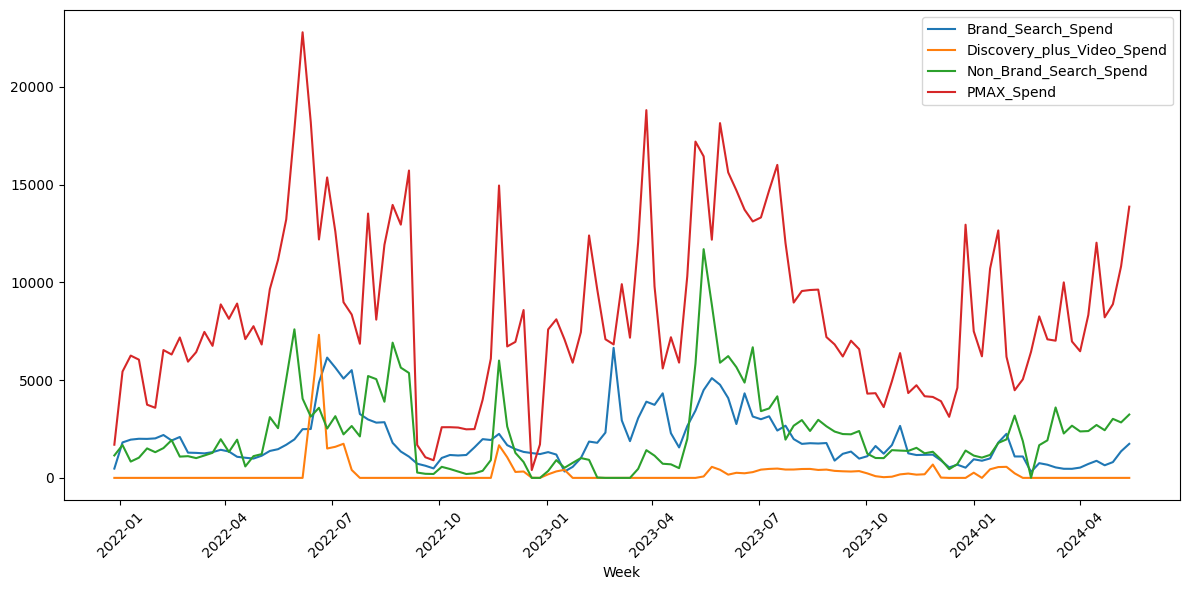

In [ ]:
# now, let's plot weekly spend
plot_category_level_weekly_line_graph(df=adwords_pivoted_df, category='Spend')

In [ ]:
# Above including Sales (New)

3. Email and SMS

In [ ]:
raw_email_df = pd.read_excel(file_path, sheet_name='Email')
raw_email_df.head()

,Day,Type,Sends
0,2024-01-01,Email,1572
1,2024-01-02,Email,1602
2,2024-01-03,Email,11088
3,2024-01-04,Email,3258
4,2024-01-05,Email,1678


In [ ]:
# clean and aggregate
raw_email_clean_df = to_week_start_monday(raw_email_df, day_column='Day'). \
  drop(columns=['Day']). \
  fillna(0).\
  groupby(['Week']). \
  agg({'Sends': 'sum'}). \
  rename(columns={'Sends': 'Email_Sends'}). \
  reset_index()


In [ ]:
raw_email_clean_df.head()

,Week,Email_Sends
0,2022-05-23,873419
1,2022-05-30,1223004
2,2022-06-06,1095099
3,2022-06-13,1227349
4,2022-06-20,1220987


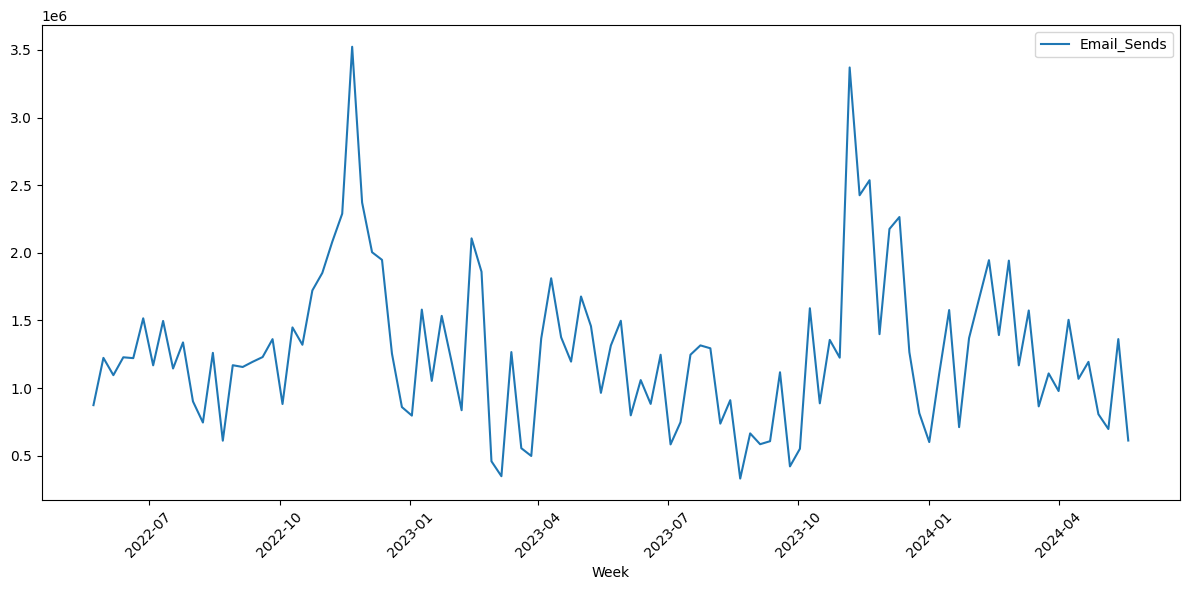

In [ ]:
# pivot
email_pivoted_df = raw_email_clean_df

# weekly sends
plot_category_level_weekly_line_graph(df=email_pivoted_df, category='Sends')

4. Discounts

In [ ]:
# Load each sheet into a pandas dataframe
discounts_df = pd.read_excel(file_path, sheet_name='Discounts')
discounts_df.head()

,Date,True Discounts
0,2022-01-01,4022.96
1,2022-01-02,4300.15
2,2022-01-03,4186.56
3,2022-01-04,3611.94
4,2022-01-05,8764.67


In [ ]:
# clean and aggregate
discounts_clean_df = to_week_start_monday(discounts_df, day_column='Date'). \
  drop(columns=['Date']). \
  fillna(0).\
  groupby(['Week']). \
  agg({'True Discounts': 'sum'}). \
  reset_index(). \
  rename(columns={'True Discounts': 'Discounts'})

discounts_clean_df.head()

,Week,Discounts
0,2021-12-27,8323.11
1,2022-01-03,33536.64
2,2022-01-10,34042.48
3,2022-01-17,33542.93
4,2022-01-24,33005.71


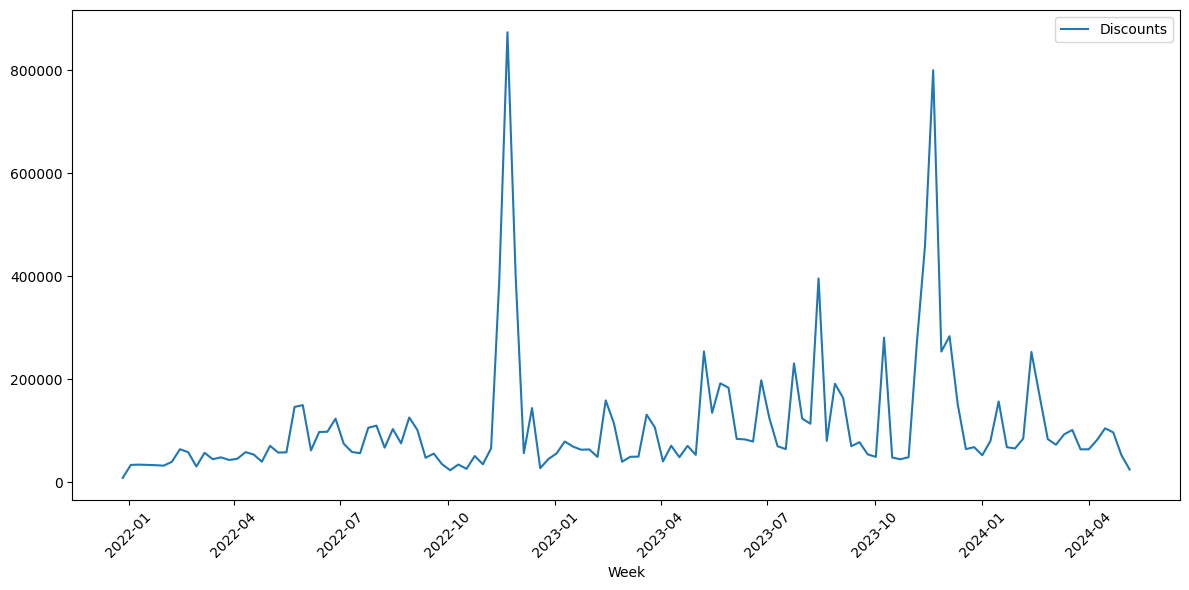

In [ ]:
plot_category_level_weekly_line_graph(df=discounts_clean_df, category='Discounts')

### Combine all data sources

In [ ]:
# create a function to merge list of dataframes by 'Week' and the join type as 'left'
def merge_dfs(dfs, join_by, join_type='left'):
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, on=join_by, how=join_type)
    return merged_df

dfs_to_join = [sales_pivoted_df, fb_pivoted_df, adwords_pivoted_df, email_pivoted_df, discounts_clean_df]

model_input_df = merge_dfs(dfs=dfs_to_join, join_by=['Week'], join_type='left').fillna(0)

model_input_df.head()

,Week,FirstTime_Sales,Returning_Sales,FB_Prospecting_Clicks,FB_Remarketing_Clicks,FB_Prospecting_Impressions,FB_Remarketing_Impressions,FB_Prospecting_Spend,FB_Remarketing_Spend,Brand_Search_Clicks,...,Brand_Search_Impressions,Discovery_plus_Video_Impressions,Non_Brand_Search_Impressions,PMAX_Impressions,Brand_Search_Spend,Discovery_plus_Video_Spend,Non_Brand_Search_Spend,PMAX_Spend,Email_Sends,Discounts
0,2022-04-25,94773.0,145218.4,10567.0,693.0,714436.0,80884.0,9807.55,1400.09,3095.0,...,9198.0,0.0,12076.0,1301828.0,988.26,0.0,1111.72,7757.20,0.0,39699.03
1,2022-05-02,110844.0,179390.4,10112.0,656.0,758841.0,76488.0,11006.54,1401.82,3046.0,...,9295.0,0.0,13151.0,1110315.0,1133.08,0.0,1215.31,6820.64,0.0,70531.57
2,2022-05-09,134153.0,201627.2,16016.0,799.0,1083088.0,93866.0,16085.70,1862.17,4187.0,...,11007.0,0.0,31948.0,1373905.0,1377.05,0.0,3107.01,9651.12,0.0,57498.63
3,2022-05-16,145968.8,199208.0,17222.0,371.0,1329242.0,64016.0,21383.74,1418.58,4741.0,...,12303.0,0.0,24710.0,1846192.0,1467.68,0.0,2541.71,11150.01,0.0,57957.60
4,2022-05-23,208179.0,379766.8,27706.0,349.0,2322903.0,64239.0,39247.20,1406.60,4724.0,...,12589.0,5.0,52864.0,2030172.0,1692.26,0.0,5045.92,13217.83,873419.0,146176.97


## Exploratory Data Analysis

### 1. Define Model Config

In [ ]:
# Date
date_field = 'Week'
model_begin_date = model_input_df[date_field].min()
model_end_date = model_input_df[date_field].max()

# Y
target = 'FirstTime_Sales'

# X
paid_media_cols = ['FB_Prospecting_Spend', 'FB_Remarketing_Spend', 'Brand_Search_Spend',
                   'Discovery_plus_Video_Spend', 'Non_Brand_Search_Spend', 'PMAX_Spend']
organic_cols = ['Email_Sends', 'Discounts']


### 2. Train vs Test Data Split

In [ ]:
# train vs test split

model_input_df.index = model_input_df[date_field]
train_end_date = model_end_date - pd.Timedelta(12, 'W')  # last 3 months as the OOS period

train = model_input_df.loc[model_begin_date:train_end_date,]
test = model_input_df.loc[train_end_date + pd.Timedelta(1, 'D'):, ]

media_data_train = train[paid_media_cols]
media_data_test = test[paid_media_cols]

organic_data_train = train[organic_cols]
organic_data_test = test[organic_cols]

target_train = train[target]
target_test = test[target]

costs_train = train[paid_media_cols].sum(axis=0)


### 3. Scale Data

In [ ]:
# define scaler objects first
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
organic_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

# scale train data
target_train_scaled = target_scaler.fit_transform(target_train.values)
media_data_train_scaled = media_scaler.fit_transform(media_data_train.values)
organic_data_train_scaled = organic_scaler.fit_transform(organic_data_train.values)
costs_scaled = cost_scaler.fit_transform(costs_train.values)

# scale test data
target_test_scaled = target_scaler.fit_transform(target_test.values)
media_data_test_scaled = media_scaler.transform(media_data_test.values)
organic_data_test_scaled = organic_scaler.transform(organic_data_test.values)


### 4. Calculate Correlation Matrix, Variation Inflation Factors (VIFs)

In [ ]:
correlations, _, _, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data_train.values),
    target_data=target_scaler.transform(target_train.values),
    cost_data=cost_scaler.transform(costs_train.values),
    extra_features_data=organic_scaler.transform(organic_data_train.values))


Correlation Matrix

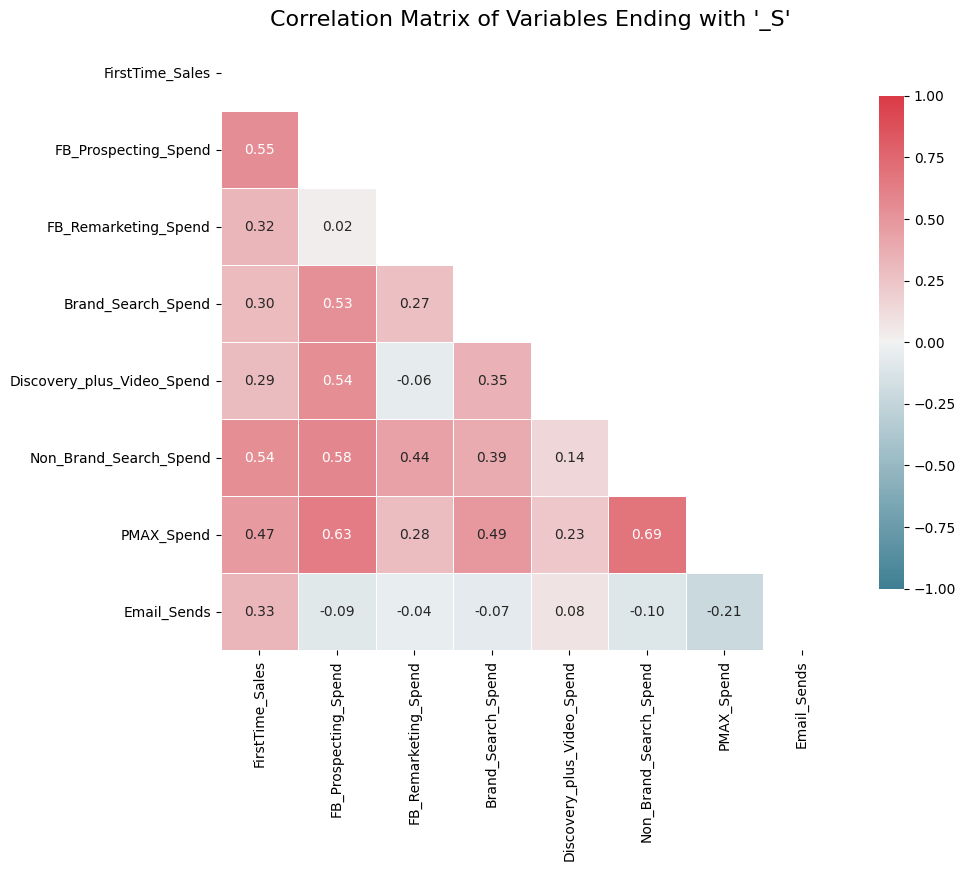

In [ ]:
# Plot the correlation matrix with only the lower diagonal
import numpy as np
import seaborn as sns

correlation_columns = [col for col in model_input_df.columns if col.endswith('_Spend') or col.endswith('_Sends')]
corr_matrix = model_input_df[['FirstTime_Sales'] + correlation_columns].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8})

plt.title("Correlation Matrix of Variables Ending with '_S'", fontsize=16)
plt.show()


Variance Inflation Factor (VIF)

In [ ]:
def highlight_high_vif_values(x: float,
                              high_vif_threshold: float=7.0) -> str:
    if x > high_vif_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variance_inflation_factors.index = [*media_data_train.columns, *organic_data_train.columns]
variance_inflation_factors = variance_inflation_factors.rename(columns={"geo_0":"vif"}).sort_values(by='vif', ascending=False)
variance_inflation_factors.style.format(precision=4).applymap(highlight_high_vif_values)


<ipython-input-46-e55b1b9febbc>:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  variance_inflation_factors.style.format(precision=4).applymap(highlight_high_vif_values)


,vif
FB_Prospecting_Spend,3.3603
Non_Brand_Search_Spend,2.7990
PMAX_Spend,2.5159
Discounts,1.7718
Email_Sends,1.7467
Brand_Search_Spend,1.7449
FB_Remarketing_Spend,1.6009
Discovery_plus_Video_Spend,1.5809


# Model Build

### 1. Hyperparameter Tuning & Selection

In [ ]:
adstock_models = ["adstock", "hill_adstock", "carryover"]

model_container = dict()
for model_name in adstock_models:
  mmm = lightweight_mmm.LightweightMMM(model_name=model_name)

  mmm.fit(
      media=media_data_train_scaled,
      media_prior=costs_scaled,
      target=target_train_scaled,
      extra_features=organic_data_train_scaled,
      degrees_seasonality=4,
      seasonality_frequency=52,
      number_warmup=1000,
      number_samples=2000,
      number_chains=2,
      media_names=paid_media_cols,
      seed=1234)

  model_container[model_name] = mmm

  # get the MAPE on Train Data
  train_prediction = mmm.predict(media=media_data_train_scaled, extra_features=organic_data_train_scaled, target_scaler=target_scaler)
  train_prediction_values = train_prediction.mean(axis=0)
  train_mape = mean_absolute_percentage_error(target_train.values, train_prediction_values)

  # get the MAPE on Test Data
  test_prediction = mmm.predict(media=media_data_test_scaled, extra_features=organic_data_test_scaled, target_scaler=target_scaler)
  test_prediction_values = test_prediction.mean(axis=0)
  test_mape = mean_absolute_percentage_error(target_test.values, test_prediction_values)

  print(f"""model_name={model_name},
  Train MAPE={round(train_mape * 100, 2)}%, Test MAPE={round(test_mape*100, 2)}%""")


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

model_name=adstock,
  Train MAPE=53.02%, Test MAPE=15.91%


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

model_name=hill_adstock,
  Train MAPE=35.54%, Test MAPE=15.9%


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

model_name=carryover,
  Train MAPE=39.34%, Test MAPE=16.91%


Best Chosen Model Based On Both Train and Test Performance : hill_adstock

Now, build the model on full data so that the model is exposed to the latest marketing trend

In [ ]:
# get the full data
media_data_full = model_input_df[paid_media_cols]
organic_data_full = model_input_df[organic_cols]
target_full = model_input_df[target]
costs_full = model_input_df[paid_media_cols].sum(axis=0)

# scale the full data
target_full_scaled = target_scaler.fit_transform(target_full.values)
media_data_full_scaled = media_scaler.fit_transform(media_data_full.values)
organic_data_full_scaled = organic_scaler.fit_transform(organic_data_full.values)
costs_scaled = cost_scaler.fit_transform(costs_full.values)

# fit the model
mmm = lightweight_mmm.LightweightMMM(model_name='hill_adstock')

mmm.fit(
    media=media_data_full_scaled,
    media_prior=costs_scaled,
    target=target_full_scaled,
    extra_features=organic_data_full_scaled,
    degrees_seasonality=4,
    seasonality_frequency=52,
    number_warmup=1000,
    number_samples=2000,
    number_chains=3,
    media_names=paid_media_cols,
    seed=1234)

# get the MAPE
prediction = mmm.predict(media=media_data_full_scaled, extra_features=organic_data_full_scaled, target_scaler=target_scaler)
prediction_values = prediction.mean(axis=0)
mape = mean_absolute_percentage_error(target_full.values, prediction_values)

print(f"""model_name={model_name}, MAPE={round(mape * 100, 2)}%""")


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

model_name=carryover, MAPE=18.19%


## Model Diagnostics

In [ ]:
# Actual vs Predicted
plot.plot_model_fit(media_mix_model=mmm, target_scaler=target_scaler)


## Model Inference

In [ ]:
# estimated coefficients' distributions
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=paid_media_cols)


In [ ]:
# overall contribution percentage
media_effect_hat, roi_hat = mmm.get_posterior_metrics(cost_scaler=cost_scaler, target_scaler=target_scaler)
plot.plot_bars_media_metrics(metric=media_effect_hat, channel_names=paid_media_cols)


In [ ]:
# decomposed sales over time
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(15,7),
                                                channel_names = paid_media_cols
                                                )